<a href="https://colab.research.google.com/github/HPCL/roofline_python/blob/main/roofline_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import io
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import plotly.graph_objects as go

## google colab users: you can run the next code cell (and comment out the jupyter code cell that is after)
## jupyter notebook users do the opposite

### change the file name to upload the json file that you want.


In [2]:
# GOOGLE COLAB
# Load the json file
#from google.colab import files
#uploaded = files.upload()

# Load 
#filename = "roofline.json"
#data = json.loads(uploaded[filename].decode("utf-8"))
#data

In [3]:
# JUPYTER NOTEBOOK
#filename = "roofline_a64_DP.json"
filename = "roofline_cascadelake_DP.json"
#filename = "roofline.json"
with open(filename) as file:
    data = json.load(file)
data

{'empirical': {'gbytes': {'data': [['L1', 13932.9],
    ['L2', 3608.6],
    ['L3', 1361.2],
    ['DRAM', 203.2]],
   'metadata': {'TIMESTAMP_DATA': [1619015024.88,
     1619015005.99,
     1619015015.51],
    'FLOPS': 1,
    'TIMESTAMP_DB': 1619020917.299774,
    'OPENMP_THREADS': 1}},
  'gflops': {'data': [['FP64 Vector GFLOPs FMA', 3499.9],
    ['FP64 Vector GFLOPs', 1749.95],
    ['FP64 Scalar GFLOPs FMA', 218.75],
    ['FP64 Scalar GFLOPs', 109.375]],
   'metadata': {'TIMESTAMP_DATA': [1619019163.24,
     1619019173.98,
     1619019184.74],
    'FLOPS': 64,
    'TIMESTAMP_DB': 1619020917.299511,
    'OPENMP_THREADS': 2}},
  'metadata': {'ERT_VERSION': '1.1.0',
   'HOSTNAME': ['cn624', [], ['192.168.100.177']],
   'CONFIG': {'ERT_WORKING_SET_MIN': ['1'],
    'ERT_CFLAGS': ['-O3',
     '-march=skylake-avx512',
     '-mtune=skylake',
     '-fopenmp-simd'],
    'ERT_CC': ['mpic++'],
    'ERT_WSS_MULT': [1.1],
    'ERT_HIP': [False],
    'ERT_MPI_CFLAGS': [],
    'ERT_MPI_LDFLAGS': [],


## Run all below to automatically decode json and create a roofline plot.

In [4]:
# Parse the gbytes section
gbytes = data['empirical']['gbytes']
gbytes

{'data': [['L1', 13932.9], ['L2', 3608.6], ['L3', 1361.2], ['DRAM', 203.2]],
 'metadata': {'TIMESTAMP_DATA': [1619015024.88, 1619015005.99, 1619015015.51],
  'FLOPS': 1,
  'TIMESTAMP_DB': 1619020917.299774,
  'OPENMP_THREADS': 1}}

In [5]:
# Load gbytes data into Pandas dataframe
gbytes_df = pd.DataFrame(gbytes['data'], columns=['name', 'slope'])
gbytes_df['slope'] = gbytes_df['slope'] 
# Add the default x and y intercept
gbytes_df['x'] = 0
gbytes_df['y'] = 0
gbytes_df

,name,slope,x,y
0,L1,13932.9,0,0
1,L2,3608.6,0,0
2,L3,1361.2,0,0
3,DRAM,203.2,0,0


In [6]:
# Parse the gflop data section
gflops = data['empirical']['gflops']
gflops

{'data': [['FP64 Vector GFLOPs FMA', 3499.9],
  ['FP64 Vector GFLOPs', 1749.95],
  ['FP64 Scalar GFLOPs FMA', 218.75],
  ['FP64 Scalar GFLOPs', 109.375]],
 'metadata': {'TIMESTAMP_DATA': [1619019163.24, 1619019173.98, 1619019184.74],
  'FLOPS': 64,
  'TIMESTAMP_DB': 1619020917.299511,
  'OPENMP_THREADS': 2}}

In [7]:
# Load gflops data into a Pandas dataframe
gflops_df = pd.DataFrame(gflops['data'], columns=['name', 'y'])
# Add the default x intercept and "slope" (really the value)
gflops_df['x'] = 100
gflops_df['slope'] = gflops['data'][0][1]
gflops_df

,name,y,x,slope
0,FP64 Vector GFLOPs FMA,3499.900,100,3499.9
1,FP64 Vector GFLOPs,1749.950,100,3499.9
2,FP64 Scalar GFLOPs FMA,218.750,100,3499.9
3,FP64 Scalar GFLOPs,109.375,100,3499.9


In [8]:
# Calculate the point where each memory line meets the peak line, add to dataframe
# y=mx+b -> x = (y-b)/m = (y-0)/m = y/m
rows = len(gbytes_df)
peak = gflops_df['y'][0]
new_xes = []

for row in range(rows):
  name = gbytes_df['name'][row]
  x = peak / gbytes_df['slope'][row]
  gbytes_df.loc[len(gbytes_df.index)] = [name, gbytes_df['slope'][row], x, peak]
  new_xes.append(x)

gbytes_df

,name,slope,x,y
0,L1,13932.9,0.000000,0.0
1,L2,3608.6,0.000000,0.0
2,L3,1361.2,0.000000,0.0
3,DRAM,203.2,0.000000,0.0
4,L1,13932.9,0.251197,3499.9
5,L2,3608.6,0.969878,3499.9
6,L3,1361.2,2.571187,3499.9
7,DRAM,203.2,17.223917,3499.9


In [9]:
# Find the x coordinate to start the peak line at
#peak_x_min = min(new_xes)
#gflops_df.loc[len(gflops_df)] = [gflops_df['name'][0], gflops_df['y'][0], peak_x_min, gflops_df['y'][0]]

In [10]:
# Find the x coordinates to start the roof lines at
peak_mem = max([m for m in gbytes_df['slope']])
peak_rows = len(gflops_df)
for i in range(peak_rows):
    x_val = gflops_df['y'][i] / peak_mem
    gflops_df.loc[len(gflops_df)] = [gflops_df['name'][i], gflops_df['y'][i], x_val, gflops_df['y'][i]]

In [11]:
# Make the label columns for the graph
gbytes_df['label'] = gbytes_df['name'] + ' ' + gbytes_df['slope'].astype(str) + ' ' + 'GB/s'
gflops_df['label'] = gflops_df['name'] + ' ' + gflops_df['slope'].astype(str) + ' ' + 'GFLOPs/s'
# Make type column for identifying later
gbytes_df['type'] = 'memory' 
gflops_df['type'] = 'peak'

In [12]:
# Concatenate the gbyte and gflop data into one dataframe to plot
g_df = pd.concat([gflops_df, gbytes_df], ignore_index=True)
g_df

,name,y,x,slope,label,type
0,FP64 Vector GFLOPs FMA,3499.900,100.000000,3499.900,FP64 Vector GFLOPs FMA 3499.9 GFLOPs/s,peak
1,FP64 Vector GFLOPs,1749.950,100.000000,3499.900,FP64 Vector GFLOPs 3499.9 GFLOPs/s,peak
2,FP64 Scalar GFLOPs FMA,218.750,100.000000,3499.900,FP64 Scalar GFLOPs FMA 3499.9 GFLOPs/s,peak
3,FP64 Scalar GFLOPs,109.375,100.000000,3499.900,FP64 Scalar GFLOPs 3499.9 GFLOPs/s,peak
4,FP64 Vector GFLOPs FMA,3499.900,0.251197,3499.900,FP64 Vector GFLOPs FMA 3499.9 GFLOPs/s,peak
5,FP64 Vector GFLOPs,1749.950,0.125598,1749.950,FP64 Vector GFLOPs 1749.95 GFLOPs/s,peak
6,FP64 Scalar GFLOPs FMA,218.750,0.015700,218.750,FP64 Scalar GFLOPs FMA 218.75 GFLOPs/s,peak
7,FP64 Scalar GFLOPs,109.375,0.007850,109.375,FP64 Scalar GFLOPs 109.375 GFLOPs/s,peak
8,L1,0.000,0.000000,13932.900,L1 13932.9 GB/s,memory
9,L2,0.000,0.000000,3608.600,L2 3608.6 GB/s,memory


In [13]:
# Get config metadata to add to a table next to the plot
host_info = gbytes['metadata'][''][3]

host_list = host_info.split("'")

host_name = host_list[1]
print(host_name)
flop_info = gbytes['metadata'][''][0]

flop_list = flop_info.split(" ")

mem_flops = flop_list[-1]
print(mem_flops)
omp_info = gbytes['metadata'][''][1]

omp_list = omp_info.split(" ")

mem_omp_threads = omp_list[1]
print(mem_omp_threads)
# Not working yet - trying to load more config data into a table to display next to the plot...
# print(type(gbytes['metadata']['']))
# config_str = gbytes['metadata'][''][6]
# print(config_str[8:])
# config = json.loads(config_str[8:])
# config
# config = [x for x in config if 'CONFIG'.]
# Load metadata into a Pandas dataframe
# metadata = pd.DataFrame(config, columns=metadata.keys())
# metadata.keys()

KeyError: ''

In [ ]:
flop_info = gflops['metadata'][''][1]
print(flop_info)
flop_list = flop_info.split(" ")
print(flop_list)
flops = flop_list[-1]
print(flops)
omp_info = gflops['metadata'][''][2]
print(omp_info)
omp_list = omp_info.split(" ")
print(omp_list)
omp_threads = omp_list[1]
print(omp_threads)

In [ ]:
import re
# parse the config file to add to the table 
metad = gflops['metadata']['']
for i in range(len(metad)):
  conf = metad[i]
  if conf.startswith('CONFIG'):
    config = metad[i]
    break
config_list = config.split("'")
config_list = config_list[1:]

config_for_pd = [('HOST',host_name)]
for j in range(0, len(config_list)-2, 4):
  # add logic to deal with flags - multiple values per key
  value = config_list[j+2]
  if re.search('[a-zA-Z0-9]', value):
    config_for_pd.append((config_list[j], value))
config_for_pd

In [ ]:
metadata_df = pd.DataFrame(config_for_pd, columns=["Config", "Value"])
metadata_df

## plot roofline without application points - using seaborn/matplotlib

ValueError: The palette list has the wrong number of colors.

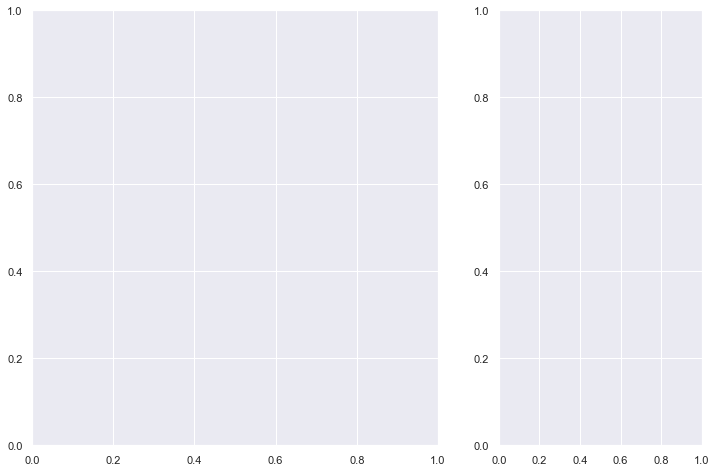

<Figure size 3456x3456 with 0 Axes>

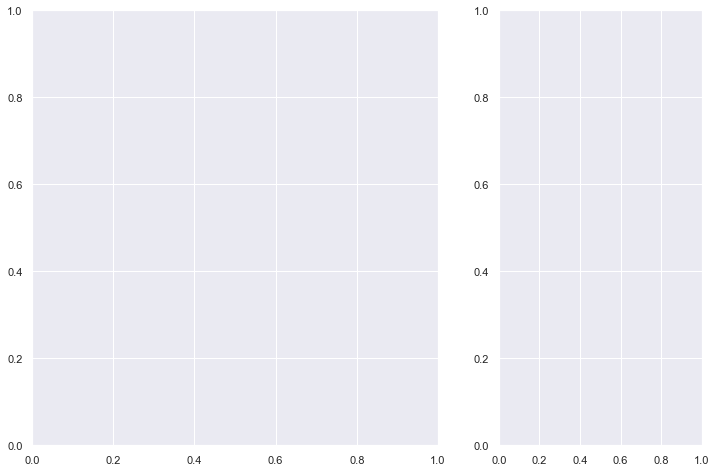

In [23]:
# calculate the axes scale
xmin =   0.01
xmax = 100.00
ymin = 10 # default
ymin = 10 ** int(math.floor(math.log10(g_df['slope'][0]*xmin)))
ymax = ymin ** int(math.floor(math.log10(g_df['slope'][0]*10)))

#calculate the midpoints for labels
xmid = math.sqrt(xmin * xmax)
ymid = g_df['slope'][0] * xmid
y0gbytes = ymid
x0gbytes = y0gbytes/g_df['slope'][0]
alpha = 1.065

# set some general plot settings
fig, (ax,ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
plt.figure(figsize=(48,48))
title = "Empirical Roofline Graph "
sns.set(rc={'figure.figsize':(12,8)})
#sns.set(font="Times New Roman",font_scale=1.8)
palette = sns.color_palette( "Dark2", int(len(g_df)/2))

# plot the lines and peak flop labels
fig, (ax,ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [2, 1]})
sns.lineplot(data=g_df, x="x", y="y", hue="label",palette=palette, ax=ax, linewidth=3)

# plot the line label(s)
for i in range(len(gflops_df.name.unique())):
    ax.text(xmax, gflops_df['y'][i]*alpha, g_df['label'][i], size='medium', ha="right")
for index in range(len(gbytes_df.name.unique())):
    mem = gbytes_df['name'][index]
    (xmax, slope) = max([(gbytes_df['x'][i],gbytes_df['slope'][i]) for i in range(len(gbytes_df['x'])) if gbytes_df['name'][i]==mem])
    xmid = math.sqrt(xmin * xmax)
    ylab = slope * xmin
    #y0gbytes = ymid
    x0gbytes = y0gbytes/slope
    alpha = 1.25
    angle = math.degrees(math.atan(slope))/2
    ax.text(x0gbytes, y0gbytes*alpha, gbytes_df['label'][index], size='medium', rotation=angle)

# add table of configs
bbox=[0, 0, 1, 1]
ax2.axis('off')
ax2.axis('tight')
mpl_table = ax2.table(cellText = metadata_df.values, bbox=bbox, colLabels=metadata_df.columns, edges='horizontal')
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

# add grid lines, title, legend
ax.grid(b=True, which='both')
ax.set_title(title, fontsize=20)
ax.legend(loc='lower right')
#sns.set(font_scale=2.5)

fig.tight_layout();

# save if desired
ax.figure.savefig("roofline.svg");

plt.show();

## Add application performance points
 - these can be loaded from a csv (below)

In [15]:
# GOOGLE COLAB
# Load the csv file
#from google.colab import files
#uploaded = files.upload()
# Load 
#csv_filename = "app_data.csv"
#app_df = pd.read_csv(csv_filename)

# JUPYTER NOTEBOOK
#csv_filename = "app_data.csv"
#csv_filename = "a64_fuj.csv"
#csv_filename = "mm_block_a64_fuj.csv"
csv_filename = "mm_block_cas_int.csv"
with open(csv_filename) as csv_file:
    app_df = pd.read_csv(csv_file)
# data

app_df['Gflops/Sec'] = (app_df['Total Flops']/app_df['Time (s)'])/1000000000
app_df

,Arithmetic Intensity,Total Flops,Time (s),Cycles,Label,Gflops/Sec
0,0.060913,1.100000e+12,20.124886,33987267505,MM default Intel,54.658695
1,0.367749,1.150000e+12,0.778172,1411543353,MM transpose Intel,1477.822384
2,0.062318,1.100000e+12,12.965219,34794798908,MM unrolljam Intel,84.842377
3,0.100600,1.520000e+12,30.566550,31811658633,MM block 64 Intel,49.727562


In [21]:
# calculate the axes scale
xmin =   0.01
xmax = 100.00
#ymin = 1 # default - change this?
#ymin = 10 ** int(math.floor(math.log10(g_df['slope'][0]*xmin)))
ymin = 1 ** int(math.floor(math.log10(g_df['slope'][0]*xmin)))
#ymin= 0.01
#ymax = ymin ** int(math.floor(math.log10(g_df['slope'][0]*1000)))
ymax = (ymin*10) ** int(math.floor(math.log10(g_df['slope'][0]*10)))

#calculate the midpoints for labels
xmid = math.sqrt(xmin * xmax)
ymid = g_df['slope'][0] * xmid
#ylabel = ymid
xlabel = ymid/g_df['slope'][0]
alpha = 1.1

# general plot settings
#title = "Empirical Roofline Graph "
sns.set(rc={'figure.figsize':(12,8)})
sns.set(font_scale=1.65)
palette = sns.color_palette( "Dark2", int(len(g_df)/2))
print(len(palette))

# plot the lines
#ax = sns.lineplot(data=g_df, x="x", y="y", hue="label",palette=palette)
#ax.set(xlabel='FLOPs / Byte', ylabel='GFLOPs / Second', fontsize=14)
#ax.set(xscale="log", yscale="log", xlim=(xmin, xmax), ylim=(ymin,ymax))

# plot the lines and peak flop label
ax = sns.lineplot(data=g_df, x="x", y="y", hue="label", palette=palette, linewidth=3)
ax.set(xlabel='FLOPs / Byte', ylabel='GFLOPs / Second')
ax.set(xscale="log", yscale="log", xlim=(xmin, xmax), ylim=(ymin,ymax))

# set axes labels and values, set log scale
ax.set(xlabel='FLOPs / Byte', ylabel='GFLOPs / Second')
ax.set(xscale="log", yscale="log", xlim=(xmin, xmax), ylim=(ymin,ymax))

# plot the line label(s)
for i in range(len(gflops_df.name.unique())):
    ax.text(xmax, gflops_df['y'][i]*alpha, g_df['label'][i], size='medium', ha="right")
for index in range(len(gbytes_df.name.unique())):
    mem = gbytes_df['name'][index]
    (xmax, slope) = max([(gbytes_df['x'][i],gbytes_df['slope'][i]) for i in range(len(gbytes_df['x'])) if gbytes_df['name'][i]==mem])
    xmid = math.sqrt(xmin * xmax)
    ylab = slope * xmin
    #xmin = ymin/slope
    mem_alpha = 1.2
    angle = math.degrees(math.atan(slope))/2-12
    ax.text(xmin, ylab*mem_alpha, gbytes_df['label'][index], size='medium', rotation=angle)

# plot the application information
ax = sns.scatterplot(x=app_df['Arithmetic Intensity'], y=app_df['Gflops/Sec'], style=app_df['Label'], hue=app_df['Label'])

ax.grid(b=True, which='both',)
#ax.set_title(title, size='large')
ax.legend(loc="lower right")

# save if desired
ax.figure.savefig("cascadelake_roofline.png")
plt.show()

8


ValueError: The palette list has the wrong number of colors.

In [18]:
# # calculate the axes scale
# xmin =   0.01
# xmax = 100.00
# ymin = 10 # default - change this?
# ymin = 10 ** int(math.floor(math.log10(g_df['slope'][0]*xmin)))
# ymax = ymin ** int(math.floor(math.log10(g_df['slope'][0]*10)))

# #calculate the midpoints for labels
# xmid = math.sqrt(xmin * xmax)
# ymid = g_df['slope'][0] * xmid
# y0gbytes = ymid
# x0gbytes = y0gbytes/g_df['slope'][0]
# alpha = 1.065

xmin =   0.01
xmax = 100.00
ymin = 10 ** int(math.floor(math.log10(g_df['slope'][0]*xmin)))
ymax = ymin ** int(math.floor(math.log10(g_df['slope'][0]*10)))

#calculate the midpoints for labels
xmid = math.sqrt(xmin * xmax)
ymid = g_df['slope'][0] * xmid
#y0gbytes = ymid
x0gbytes = ymid/g_df['slope'][0]
alpha = 1.065


# general plot settings
title = "Empirical Roofline Graph "
#sns.set(rc={'figure.figsize':(12,8)})
palette = sns.color_palette( "Dark2", int(len(g_df)/2))
print(len(palette)

# plot the lines
ax = sns.lineplot(data=g_df, x="x", y="y", hue="label",palette=palette)
ax.set(xlabel='FLOPs / Byte', ylabel='GFLOPs / Second')
ax.set(xscale="log", yscale="log", xlim=(xmin, xmax), ylim=(ymin,ymax))
#ax = sns.lineplot(x=[0.85849, 0.85849], y=[0.0,1406.31], palette="Dark2_r")
#print(len(ax.lines))
#ax.lines[4].set_linestyle("--")

# plot the line label(s)
for i in range(len(gflops_df.name.unique())):
    ax.text(xmax, ymid*alpha, g_df['label'][i], size='medium', ha="right")
for index in range(len(gbytes_df.name.unique())):
    mem = gbytes_df['name'][index]
    (xmax, slope) = max([(gbytes_df['x'][i],gbytes_df['slope'][i]) for i in range(len(gbytes_df['x'])) if gbytes_df['name'][i]==mem])
    xmid = math.sqrt(xmin * xmax)
    ymid = slope * xmid
    y0gbytes = ymid
    x0gbytes = y0gbytes/slope
    alpha = 1.2
    angle = math.degrees(math.atan(slope))/2-4
    ax.text(x0gbytes, y0gbytes*alpha, gbytes_df['label'][index], size='medium', rotation=angle)

ax.grid(b=True, which='both',)
ax.set_title(title, size='large')
ax.legend(loc="lower right")

#ymaxx = 1-(1406.31/10000)
#plt.axvline(x=0.85849, ymax=.72,  color="k", linestyle='--', )
#ax.text(0.85849*0.8, y0gbytes, "Machine Balance", size='medium', rotation=90)

# save if desired
ax.figure.savefig("roofline.svg")
plt.show()

SyntaxError: invalid syntax (<ipython-input-18-c77b9ebcda38>, line 35)

### Plotly Version (Work in Progress)

In [ ]:
# plot! plotly version
fig = go.Figure()
elements = g_df['name'].unique()
fig.update_xaxes(type="log", range=[-1,2]) 
fig.update_yaxes(type="log", range=[1,4])
# Create traces
for cur_name in elements:
  index = (g_df[g_df['name']==cur_name].index.values)[0]
  x_vals = [g_df['x'][i] for i in range(g_df.shape[0]) if g_df['name'][i] == cur_name]
  y_vals = [g_df['y'][i] for i in range(g_df.shape[0]) if g_df['name'][i] == cur_name]
  fig.add_trace(go.Scatter(x=x_vals, y=y_vals,
                      mode="lines",
                      name=g_df['label'][index]
                      ))
  slope = g_df['slope'][index]
  # get the mid-ish point to add the label
  #calculate the midpoints for labels
  xmid = math.sqrt(xmin * xmax)
  ymid = slope * xmid
  y0gbytes = ymid
  x0gbytes = y0gbytes/slope
  fig.add_annotation(text=cur_name+str(slope),
                  xref="paper", yref="paper",
                  x=x0gbytes, y=y0gbytes, showarrow=False,
                  textangle=-45)
fig.update_layout(
    autosize=False,
    width=1200,
    height=800,
    title="Empirical Roofline Graph",
    xaxis_title="FLOPs / Byte",
    yaxis_title="GFLOPs / Second"
)


fig.show()